# Algoritmo Genético aplicado ao Problema do Caixeiro Viajante

Este notebook apresenta uma implementação do Algoritmo Genético (AG), uma metaheurística inspirada na teoria da evolução de Charles Darwin, para resolver o Problema do Caixeiro Viajante (TSP).

## 1. Introdução ao Algoritmo Genético (AG)

O **Algoritmo Genético** é uma técnica de busca e otimização baseada nos princípios da genética e da seleção natural. Ele opera sobre uma população de soluções candidatas (indivíduos), evoluindo-as iterativamente em direção a uma solução ótima.

### Componentes principais de um Algoritmo Genético:

1.  **População**: Um conjunto de indivíduos, onde cada indivíduo representa uma solução potencial para o problema.
2.  **Cromossomo**: A representação de um indivíduo. No caso do TSP, um cromossomo é uma permutação das cidades, representando uma rota.
3.  **Função de Aptidão (Fitness)**: Uma função que avalia a qualidade de cada indivíduo. Para o TSP, a aptidão é inversamente proporcional à distância total da rota (rotas mais curtas são mais aptas).
4.  **Seleção**: O processo de escolha dos indivíduos mais aptos (pais) para a reprodução. Métodos comuns incluem a seleção por torneio e roleta.
5.  **Cruzamento (Crossover)**: Combina o material genético de dois pais para gerar um ou mais descendentes (filhos), que herdam características de ambos.
6.  **Mutação**: Introduz pequenas alterações aleatórias nos cromossomos dos descendentes, garantindo diversidade na população e evitando a convergência para ótimos locais.
7.  **Elitismo**: Garante que os melhores indivíduos de uma geração sejam transferidos diretamente para a próxima, evitando a perda de boas soluções.

### Pseudocódigo geral do Algoritmo Genético:

```
função Algoritmo_Genetico():
    Inicializar população com soluções aleatórias
    Avaliar a aptidão de cada indivíduo
    
    para i = 1 até max_geracoes:
        Selecionar pais com base na aptidão
        Gerar descendentes através de Crossover e Mutação
        Avaliar a aptidão dos novos descendentes
        Substituir a população antiga pela nova (mantendo os melhores com Elitismo)
    
    Retornar o melhor indivíduo encontrado
```

## 2. Importando as bibliotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

## 3. Gerando um problema TSP aleatório

In [2]:
def generate_random_tsp(n_cities, seed=42):
    """
    Gera um problema TSP aleatório com n_cities em um plano 2D.
    
    Args:
        n_cities: Número de cidades
        seed: Semente para reprodutibilidade
        
    Returns:
        cities: Array de coordenadas (x, y) das cidades
        distance_matrix: Matriz de distâncias entre as cidades
    """
    np.random.seed(seed)
    # Gera coordenadas aleatórias das cidades em um plano 100x100
    cities = np.random.rand(n_cities, 2) * 100
    
    # Calcula a matriz de distâncias euclidianas entre todas as cidades
    distance_matrix = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(i+1, n_cities):
            distance = np.sqrt(np.sum((cities[i] - cities[j])**2))
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    return cities, distance_matrix

## 4. Funções para visualização da solução

In [3]:
def plot_tsp_solution(cities, tour, title="Solução TSP"):
    """
    Plota o caminho do caixeiro viajante no plano 2D.
    
    Args:
        cities: Array de coordenadas (x, y) das cidades
        tour: Lista com a ordem de visita das cidades
        title: Título do gráfico
    """
    plt.figure(figsize=(10, 8))
    
    # Plota as cidades
    plt.scatter(cities[:, 0], cities[:, 1], c='red', s=50, zorder=2)
    
    # Numera as cidades
    for i, (x, y) in enumerate(cities):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')
    
    # Cria o caminho do tour, incluindo o retorno à cidade inicial
    tour_cities = np.array([cities[i] for i in tour + [tour[0]]])
    plt.plot(tour_cities[:, 0], tour_cities[:, 1], 'b-', linewidth=1.5, alpha=0.8, zorder=1)
    
    # Destaca a cidade inicial
    plt.scatter(cities[tour[0], 0], cities[tour[0], 1], c='green', s=100, label='Cidade inicial', zorder=3)
    
    plt.title(title)
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5. Implementação do Algoritmo Genético para o TSP

### 5.1 Funções Auxiliares (Indivíduo, População e Aptidão)

In [4]:
def calculate_tour_distance(tour, distance_matrix):
    """Calcula a distância total de um tour."""
    total_distance = 0
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        total_distance += distance_matrix[tour[i], tour[j]]
    return total_distance

def create_random_tour(n_cities):
    """Cria um indivíduo (tour) aleatório."""
    tour = list(range(n_cities))
    random.shuffle(tour)
    return tour

def create_initial_population(pop_size, n_cities):
    """Cria uma população inicial de tours aleatórios."""
    return [create_random_tour(n_cities) for _ in range(pop_size)]

def calculate_fitness(population, distance_matrix):
    """Calcula a aptidão de cada indivíduo na população."""
    fitness_scores = []
    for tour in population:
        distance = calculate_tour_distance(tour, distance_matrix)
        # A aptidão é o inverso da distância para que rotas menores tenham maior aptidão
        fitness_scores.append(1 / distance)
    return np.array(fitness_scores)

### 5.2 Operadores Genéticos

Implementaremos os operadores de Seleção, Crossover e Mutação.

In [5]:
def tournament_selection(population, fitness, tournament_size=2):
    """Seleciona um pai usando o método de torneio."""
    selection_ix = np.random.randint(len(population), size=tournament_size)
    selection_fitness = fitness[selection_ix]
    winner_ix = selection_ix[np.argmax(selection_fitness)]
    return population[winner_ix]

def ordered_crossover(parent1, parent2):
    """Realiza o Crossover Ordenado (OX1)."""
    size = len(parent1)
    child = [None] * size
    
    # Seleciona um subconjunto aleatório do primeiro pai
    start, end = sorted(random.sample(range(size), 2))
    child[start:end] = parent1[start:end]
    
    # Preenche o restante com os genes do segundo pai na ordem em que aparecem
    parent2_genes = [item for item in parent2 if item not in child]
    
    pointer = 0
    for i in range(size):
        if child[i] is None:
            child[i] = parent2_genes[pointer]
            pointer += 1
            
    return child

def swap_mutation(tour, mutation_rate=0.01):
    """Aplica a mutação de troca."""
    mutated_tour = tour[:]
    for i in range(len(mutated_tour)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(mutated_tour) - 1)
            mutated_tour[i], mutated_tour[j] = mutated_tour[j], mutated_tour[i]
    return mutated_tour

### 5.3 Implementação do Algoritmo Genético completo

In [6]:
def genetic_algorithm(distance_matrix, n_cities, pop_size=100, n_generations=500, mutation_rate=0.01, elitism_size=5):
    """
    Implementação completa do Algoritmo Genético para o TSP.
    """
    # Inicialização
    population = create_initial_population(pop_size, n_cities)
    best_distance_history = []
    best_tour_overall = None
    best_distance_overall = float('inf')

    # Loop de Gerações
    for gen in range(n_generations):
        fitness = calculate_fitness(population, distance_matrix)
        
        # Encontra o melhor da geração atual
        best_idx = np.argmax(fitness)
        best_tour_gen = population[best_idx]
        best_distance_gen = 1 / fitness[best_idx]
        
        # Atualiza o melhor global
        if best_distance_gen < best_distance_overall:
            best_distance_overall = best_distance_gen
            best_tour_overall = best_tour_gen
        
        best_distance_history.append(best_distance_overall)

        # Cria a nova geração
        new_population = []
        
        # Elitismo: mantém os melhores indivíduos
        elite_indices = np.argsort(fitness)[-elitism_size:]
        for idx in elite_indices:
            new_population.append(population[idx])
            
        # Crossover e Mutação
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitness)
            parent2 = tournament_selection(population, fitness)
            
            child = ordered_crossover(parent1, parent2)
            mutated_child = swap_mutation(child, mutation_rate)
            
            new_population.append(mutated_child)
        
        population = new_population
        
        if (gen + 1) % 50 == 0:
            print(f"Geração {gen + 1}: Melhor Distância = {best_distance_overall:.2f}")

    return best_tour_overall, best_distance_overall, best_distance_history

## 6. Executando o Algoritmo Genético

In [7]:
# Definir parâmetros
N_CITIES = 20
POP_SIZE = 100
N_GENERATIONS = 500
MUTATION_RATE = 0.02
ELITISM_SIZE = 10

# Gerar um problema TSP aleatório
cities, distance_matrix = generate_random_tsp(N_CITIES, seed=42)

# Executar o algoritmo genético
start_time = time.time()
best_tour, best_distance, history = genetic_algorithm(
    distance_matrix, 
    n_cities=N_CITIES,
    pop_size=POP_SIZE,
    n_generations=N_GENERATIONS,
    mutation_rate=MUTATION_RATE,
    elitism_size=ELITISM_SIZE
)
execution_time = time.time() - start_time

print(f"\nMelhor solução encontrada: {best_tour}")
print(f"Distância total do tour: {best_distance:.2f}")
print(f"Tempo de execução: {execution_time:.2f} segundos")

Geração 50: Melhor Distância = 439.75
Geração 100: Melhor Distância = 430.09
Geração 150: Melhor Distância = 415.38
Geração 200: Melhor Distância = 386.43
Geração 250: Melhor Distância = 386.43
Geração 300: Melhor Distância = 386.43
Geração 350: Melhor Distância = 386.43
Geração 400: Melhor Distância = 386.43
Geração 450: Melhor Distância = 386.43
Geração 500: Melhor Distância = 386.43

Melhor solução encontrada: [17, 4, 12, 0, 16, 5, 3, 13, 8, 11, 7, 2, 18, 9, 15, 10, 14, 6, 19, 1]
Distância total do tour: 386.43
Tempo de execução: 1.36 segundos


## 7. Visualizando a solução e o progresso do algoritmo

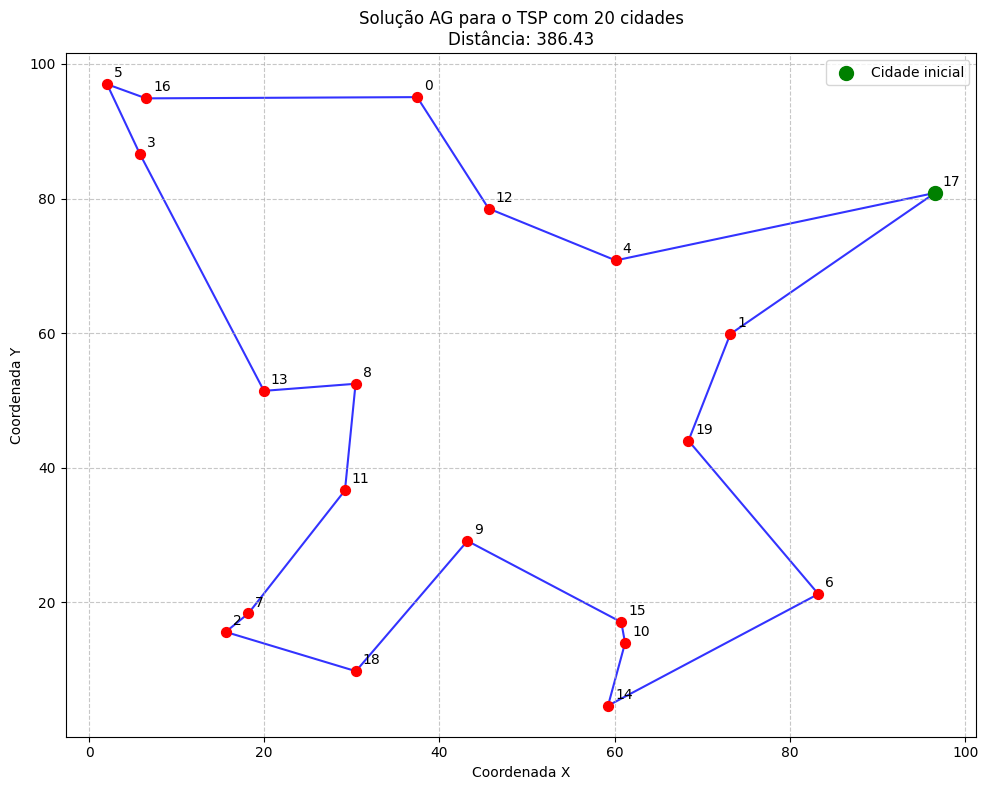

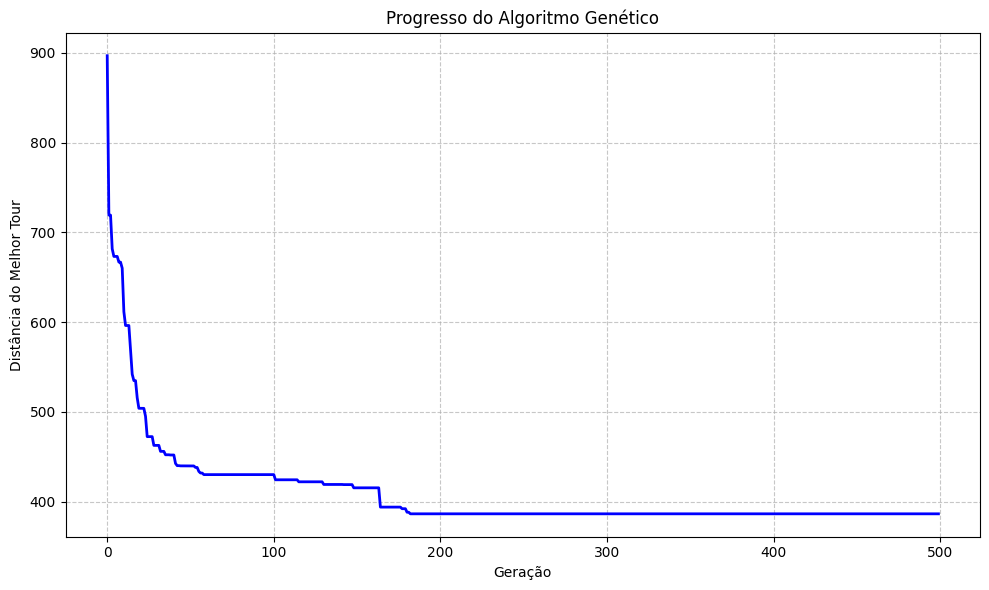

In [8]:
# Plotar a solução final
plot_tsp_solution(cities, best_tour, title=f"Solução AG para o TSP com {N_CITIES} cidades\nDistância: {best_distance:.2f}")

# Plotar o progresso do algoritmo
plt.figure(figsize=(10, 6))
plt.plot(history, 'b-', linewidth=2)
plt.xlabel('Geração')
plt.ylabel('Distância do Melhor Tour')
plt.title('Progresso do Algoritmo Genético')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8. Conclusão

Neste notebook, implementamos o Algoritmo Genético para resolver o Problema do Caixeiro Viajante. Vimos como os princípios da evolução natural podem ser aplicados para encontrar soluções de alta qualidade para um problema de otimização complexo.

### Vantagens do Algoritmo Genético:
- **Busca Robusta**: Explora uma grande parte do espaço de busca, sendo eficaz em evitar ótimos locais.
- **Paralelismo Intrínseco**: A avaliação da aptidão da população pode ser facilmente paralelizada.
- **Flexibilidade**: Pode ser aplicado a uma vasta gama de problemas, exigindo apenas uma representação de cromossomo e uma função de aptidão.

### Desafios:
- **Ajuste de Parâmetros**: O desempenho do AG é sensível a parâmetros como tamanho da população, taxas de crossover e mutação, e critério de parada. A escolha adequada desses parâmetros muitas vezes requer experimentação.
- **Convergência Prematura**: A população pode convergir para uma solução subótima se a diversidade genética for perdida muito rapidamente.

O Algoritmo Genético é uma ferramenta poderosa e amplamente utilizada em otimização, inteligência artificial e aprendizado de máquina, oferecendo um bom equilíbrio entre a exploração de novas soluções e a intensificação da busca em regiões promissoras.

## 9. Referências

1.  Holland, J. H. (1975). *Adaptation in Natural and Artificial Systems*. University of Michigan Press.
2.  Goldberg, D. E. (1989). *Genetic Algorithms in Search, Optimization, and Machine Learning*. Addison-Wesley.
3.  Eiben, A. E., & Smith, J. E. (2015). *Introduction to Evolutionary Computing*. Springer.